#Model to analyze loans


This dataset contains applicant and loan-related information.

The goal is to build a classification model to predict loan approval.

Helps-business reduce risk, improve decision making

Supervised classification problem. because we are using labeled data with known outcomes to predict one of two possible classes.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score,  roc_curve, accuracy_score, confusion_matrix

First I load the data, explore data structure, check data types, understand feature distribution

In [ ]:
# Load CSV into DataFrame
df = pd.read_csv('loans_modified.csv')

In [ ]:
df.head()


,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,0.0
1,LP001005,Male,Yes,0,Graduate,NaN,3000.0,0.0,66.0,360.0,1.0,Urban,1.0
2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,1.0
3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,1.0
4,LP001011,Male,Yes,2,Graduate,Yes,5417.0,4196.0,267.0,360.0,1.0,Urban,1.0


here **Target Variable** - loan_status

other columns are **input features**

########

gender - male or female - possibl bias

married - Financial stability

Dependents - More dependents = higher expenses

education - earning potential

self_employed	- Income stability

applicant_income	- Main repayment source

coapplicant_income	- Extra financial support

loan_amount	- Risk exposure

loan_amount_term	- Monthly burden

credit_history	- Strongest predictor usually

property_area - Economic environment

loan_status - Approval outcome

In [ ]:
df.shape

(563, 13)

In [ ]:
#understand the null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             534 non-null    object 
 1   gender              534 non-null    object 
 2   married             544 non-null    object 
 3   dependents          531 non-null    object 
 4   education           541 non-null    object 
 5   self_employed       529 non-null    object 
 6   applicant_income    537 non-null    float64
 7   coapplicant_income  529 non-null    float64
 8   loan_amount         533 non-null    float64
 9   loan_amount_term    535 non-null    float64
 10  credit_history      541 non-null    float64
 11  property_area       542 non-null    object 
 12  loan_status         535 non-null    float64
dtypes: float64(6), object(7)
memory usage: 57.3+ KB


In [ ]:
#Understand the missing values. This shows how many nulls each column has.
df.isnull().sum()

,0
loan_id,29
gender,29
married,19
dependents,32
education,22
self_employed,34
applicant_income,26
coapplicant_income,34
loan_amount,30
loan_amount_term,28


Serveral numeric column have missing values and dropping nulls removes too many rows, I would impute rather dropping, such as filling categorical values with mode and numerical values with median.


Since loan_status has missing values I would drop those rows as it is the target variable and we cannot train wihout lables.

Dropping them would remove most of the dataset and hurt model performance.

In [ ]:
#Basic descriptive statistics
df.describe()

,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,loan_status
count,537.000000,529.000000,533.000000,535.000000,541.000000,535.000000
mean,5379.370577,1692.604764,147.433396,341.674766,0.878004,0.717757
std,6064.809533,3093.379309,85.851735,65.301425,0.327584,0.450512
min,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000
25%,2894.000000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,3762.000000,1250.000000,128.000000,360.000000,1.000000,1.000000
75%,5818.000000,2333.000000,172.000000,360.000000,1.000000,1.000000
max,81000.000000,41667.000000,650.000000,480.000000,1.000000,1.000000


Income variable - right skewed

applicant_income max = 81000 vs median = 3762

co-applicant_income max = 41667 vs median = 1250

Extreme outliers so consider sacling to stabilize the model

###########

loan amount distribution is also skewed

loan_amount = 650 Vs median = 128

###########

Credit_history is mostly skewed towards 1

mean 0.878 and median = 1

so we need to check its relationship to loan status

##########

Target loan_status is imbalanced
loan_status mean = 0.717 -> 72% approved, 28% rejected

loan_status is binary, its mean represent the proportion of approvals. A mean of 0.72 shows that approvaed loans dominate, so the target is moderatley imbalanced.

so we need to use **class weighting and evaluation metics** beyond accuary. (to handle class imbalance, ensuring the model does not ignore the minority class and more reliable performance evaluation. )

Credit_history is mostly positive, target imbalance with around 72% approval



In [ ]:
#Target distribution incluing NaN
df['loan_status'].value_counts(normalize=True)
#the normalize=True part return proportions (percentages) instead of raw counts.

,proportion
loan_status,
1.0,0.717757
0.0,0.282243


I would check using value_counts(normalize=True).
If one class dominates, then the dataset is imbalanced.

How can you handle imbalance?

There are several ways:

Resampling (oversampling / undersampling)

Using SMOTE

Using class_weight in models

Adjusting decision threshold

 -- LogisticRegression(class_weight='balanced')

 class weights - simple, avoids changing the data distribution.

In [ ]:
#loan_id is not relevent so dropping that column
#remove loan_id because it is only an identifier with no predictive meaning and could introduce noise or misleading patterns into the model.

df = df.drop('loan_id', axis = 1)

# We use axis=1 because we are removing a column, and in pandas axis=1 refers to columns while axis=0 refers to rows.


In [ ]:
#We calculate the proportion of approved and rejected loans for each credit history group to analyze their relationship.
#We use this to see how loan approval rates differ by credit history,
#helping us understand the relationship between credit history and loan status.
#normalize='index' converts each row into percentages

pd.crosstab(df['credit_history'], df['loan_status'], normalize='index')

loan_status,0.0,1.0
credit_history,,
0.0,0.870968,0.129032
1.0,0.200883,0.799117


Applicants with good credit history have around an 80% approval rate, while those without it have only about 13%, showing that credit history strongly influences loan approval. Having good credit history massively increases chances of loan approval.

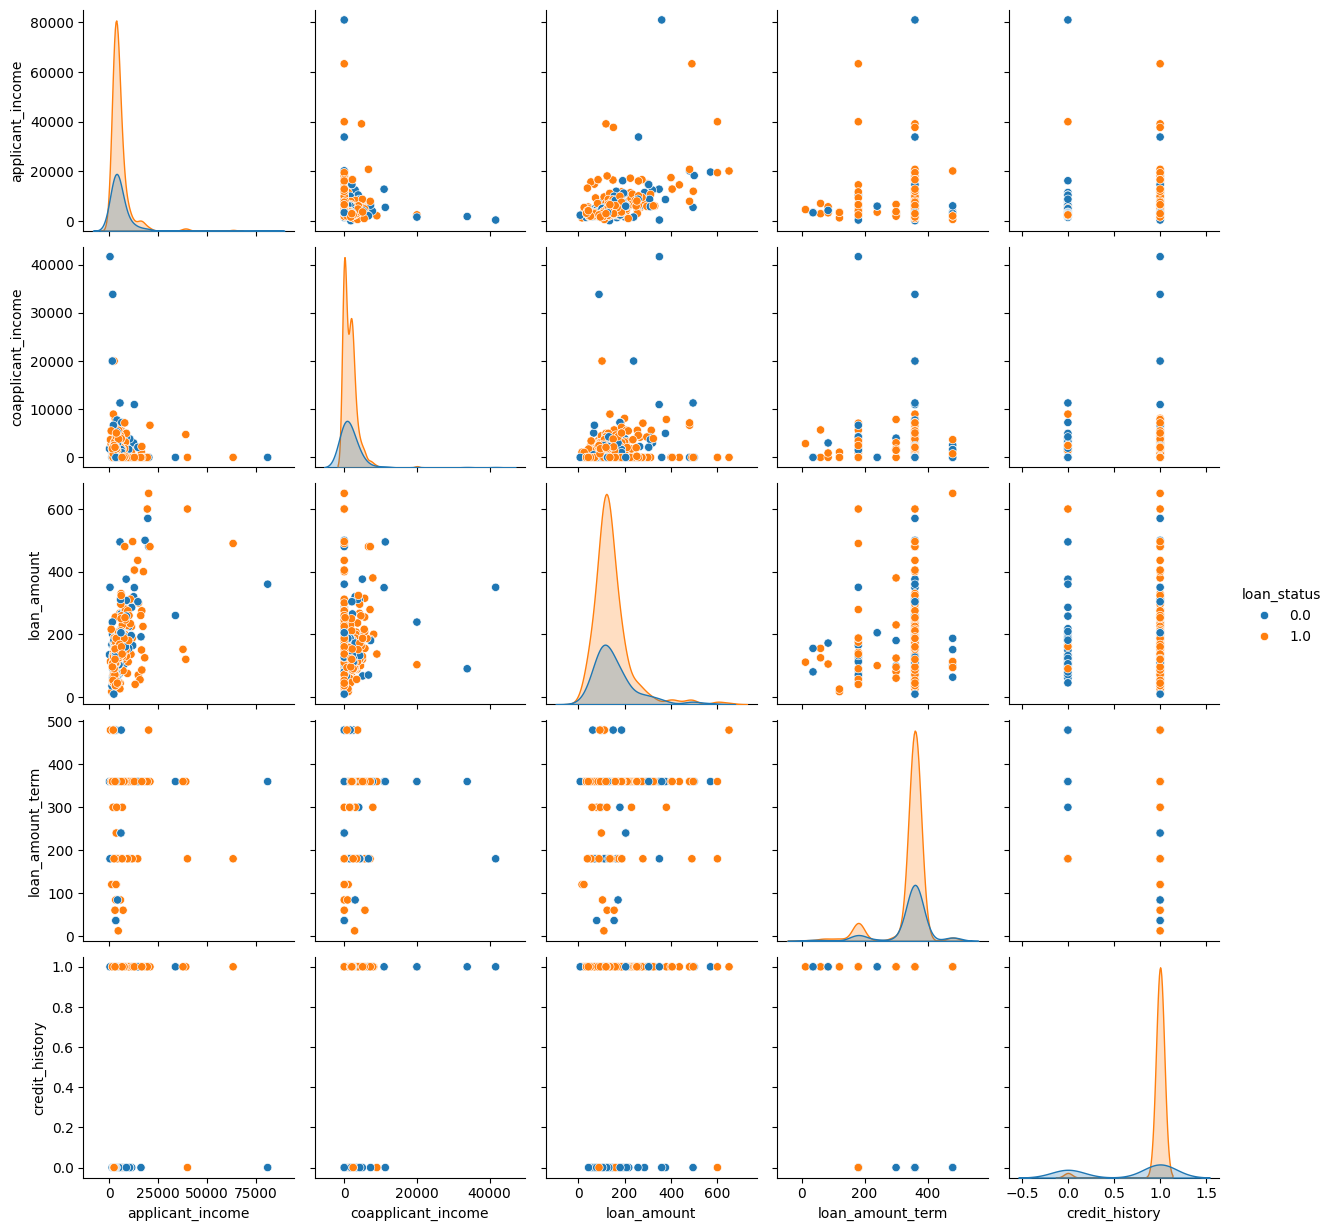

In [ ]:
#We use a pareplot to visualize relationships and distributions between features colored by loan status,
#helping us see patterns and class separation. hue is used to color the data points by a specific variable

sns.pairplot(df, hue = 'loan_status')
plt.show()

# Right-skewed means the data has a long tail to the right with a few very large values,
#while left-skewed means it has a long tail to the left with a few very small values.
#It denotes that the data is not symmetrically distributed and contains outliers

In [ ]:
#Drop rows with missing target variable

df = df.dropna(subset=['loan_status'])
# To avoid chained assignment issues and ensure safe modifications.

df["loan_status"] = df["loan_status"].astype(int)

#After removing missing labels, I converted the target to integer format to clearly represent class labels.
#Class labels, usually integers (0, 1).

In [ ]:
df.shape

(535, 12)

In [ ]:
#Impute missing features Numeric filled with median, Categorical filled with mode
#mode for categorical data because it represents the most common category,
#and median for numerical data because it is good to outliers,
#unlike the mean which can be distorted by extreme values.

cat_cols = df.select_dtypes(include="object").columns
num_cols = df.select_dtypes(exclude="object").columns.drop("loan_status")

In [ ]:
# Fill categorical with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numeric with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

#[0] to take the first (most frequent) value from the mode result

In [ ]:
# machine learning models only work with numerical values, so categorical variables must
#be converted into numbers.Since models require numeric input , we need to converted
#categorical features using encoding. we need to add labelenocoder
#cat_cols = ['gender', 'married', 'dependents','education', 'self_employed', 'property_area' ]
le = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,1,1,1,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0
1,1,1,0,0,0,3000.0,0.0,66.0,360.0,1.0,2,1
2,1,1,0,1,0,2583.0,2358.0,120.0,360.0,1.0,2,1
3,1,0,0,0,0,6000.0,0.0,141.0,360.0,1.0,2,1
4,1,1,2,0,1,5417.0,4196.0,267.0,360.0,1.0,2,1


In [ ]:
#Feature Engineering
#represent repayment ability
df['total_income'] = df['applicant_income'] + df['coapplicant_income']
df['loan_income_ratio'] = df['loan_amount'] / df['total_income']

###we need to remove the target (variable) column before training

Because the target is what we are trying to predict. If we include it in the features, the model will leak information and give unrealistically good results.

###What happens if we train and test on the same data

The model will memorize the data and give overly optimistic performance that does not reflect real-world behavior.

We split the data to test the model on unseen data and measure how well it generalizes, helping prevent overfitting.

In [ ]:
#Train-Test Split
#Split to evaluate how well the model generalizes to unseen data and to avoid overfitting.
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# axis=1 means we are dropping a column,
# test_size=0.2 means 20% of the data is used for testing,
# random_state=42 ensures the split is reproducible.
# stratify - To preserve the original class distribution in both sets.

In [ ]:
X_train.head()

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,total_income,loan_income_ratio
466,0,0,0,1,1,18165.0,0.0,125.0,360.0,1.0,2,18165.0,0.006881
323,1,1,3,0,0,8750.0,4996.0,130.0,360.0,1.0,0,13746.0,0.009457
109,1,0,0,0,0,2014.0,1929.0,74.0,360.0,1.0,2,3943.0,0.018767
151,1,1,2,0,0,2045.0,1619.0,101.0,360.0,1.0,0,3664.0,0.027566
158,1,1,1,0,0,33846.0,0.0,260.0,360.0,1.0,1,33846.0,0.007682


In [ ]:
# I would start with Logistic Regression because it is simple,
#fast, interpretable, and works well as a baseline for binary classification.
model = LogisticRegression(max_iter=6000, class_weight="balanced")

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=6000)

max_iter sets the maximum number of training iterations to ensure the model converges

class_weight balances the impact of imbalanced classes

model.fit() trains the model by learning patterns from the training data.

In [ ]:
# Predictions: to generate predicted loan approval labels for unseen test data so we can evaluate how well the model performs.
y_pred = model.predict(X_test)


In [ ]:
#Evaluation
print(classification_report(y_test, y_pred))
print("Acc", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.43      0.45        30
           1       0.78      0.81      0.79        77

    accuracy                           0.70       107
   macro avg       0.62      0.62      0.62       107
weighted avg       0.69      0.70      0.70       107

Acc 0.7009345794392523


**Precision** measures how many predicted positives are correct

**recall** measures how many actual positives are detected,

**F1-score** balances precision and recall,

**support** shows how many samples belong to each class

**accuracy** shows the overall proportion of correct predictions.

##Final Result

Precision: 0.46
Recall:    0.43
F1:        0.45

Interpretation:

Precision 0.46
→ When model predicts “Rejected”, it’s right only 46% of the time ❌

Recall 0.43
→ It only catches 43% of bad loans ❌

So:

👉 Model is weak at identifying risky loans.

Precision: 0.78
Recall:    0.81
F1:        0.79
Interpretation:
Fairly good performance on approvals ✅

Much better than class 0

So:

👉 Model favors approvals (expected with imbalance).

Overall Accuracy
Accuracy ≈ 70%


This is lower than 72% baseline, which means:

A naive “always approve” model would get ~72%.

So your model:

⚠️ Improves balance
❌ But hurts accuracy

This is normal when handling imbalance.


The model achieved around 70% accuracy, with stronger performance on approved loans than rejected ones. Precision and recall for rejected loans are relatively low, indicating difficulty in identifying risky applicants. This is likely due to class imbalance, limited features, and the use of a simple linear model. I prioritized balanced performance over pure accuracy using class weighting. With more features and non-linear models, performance could be improved.

It can be used as a screening tool or baseline, but not as a final decision system without further improvements and validation.

The model performs reasonably on approvals but struggles with rejections due to imbalance and limited features, which is expected for a baseline logistic regression.

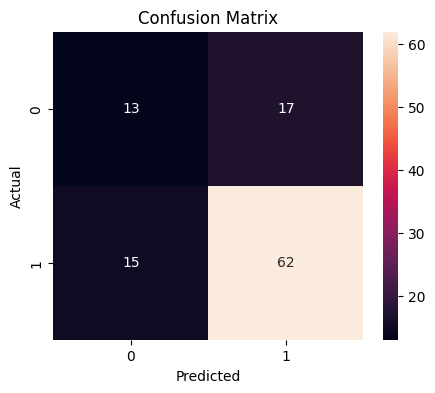

In [ ]:
#confusion matrix to see exactly how many predictions were correct or incorrect for each class,
#helping us understand the types of errors the model makes.
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#annot=True displays the numbers inside each cell of the confusion matrix,
#fmt="d" formats those numbers as integers so they are easy to read.

ROC-AUC: 0.583982683982684


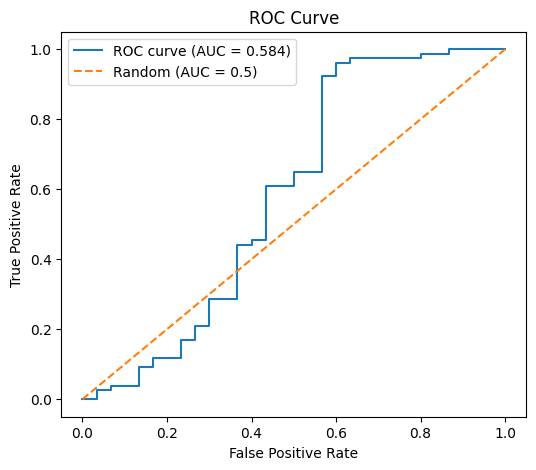

In [ ]:
#Accuracy is misleading. ROC-AUC shows real model quality
#ROC-AUC - A randomly chosen approved loan gets a higher score than a randomly chosen rejected loan.
# 0.5 - not good, 0.6–0.7 - weak, 0.7–0.8 - good, >0.8- very good
#ROC-AUC evaluates ranking performance across thresholds and is good to class imbalance,
#making it more informative than accuracy for this problem.
# 12) ROC-AUC Score + ROC Curve (ADDED)
# =========================
# IMPORTANT: ROC-AUC needs probabilities, not class labels
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.5)")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
print("\nFINAL RESULTS DISCUSSION:")
print(
    "- The model performs better on class 1 (Approved) than class 0 (Rejected), which is expected due to class imbalance.\n"
    "- Accuracy alone can be misleading in imbalanced datasets, so I also report precision/recall/F1 and ROC-AUC.\n"
    "- ROC-AUC evaluates how well the model ranks approvals vs rejections across thresholds.\n"
    "- Next steps would include feature engineering, threshold tuning, and trying non-linear models (e.g., tree-based) if business needs justify it."
)


FINAL RESULTS DISCUSSION:
- The model performs better on class 1 (Approved) than class 0 (Rejected), which is expected due to class imbalance.
- Accuracy alone can be misleading in imbalanced datasets, so I also report precision/recall/F1 and ROC-AUC.
- ROC-AUC evaluates how well the model ranks approvals vs rejections across thresholds.
- Next steps would include feature engineering, threshold tuning, and trying non-linear models (e.g., tree-based) if business needs justify it.


In [ ]:
#Model Interpretation
model.coef_

array([[ 2.36170345e-01,  4.10744380e-01,  8.40792937e-02,
        -3.49194515e-01, -1.41859658e-01,  1.55726453e-05,
        -3.26350306e-05, -2.90409294e-03, -4.74184513e-03,
         2.94354633e+00,  1.32025943e-01, -1.70623825e-05,
        -6.45506630e-02]])

-- Which metrics would you use?

Since this is a loan approval problem, I would focus on precision, recall, F1-score, and ROC-AUC in addition to accuracy.

-- Why is accuracy not enough?

If the data is imbalanced, a model can achieve high accuracy by always predicting the majority class, but still perform poorly.

-- Which error is more dangerous here?

Approving a bad loan (false positive) is more costly, so I would focus on precision.

-- What is overfitting?

When a model performs well on training data but poorly on unseen data.

-- How do you reduce overfitting?


Using regularization, simpler models, cross-validation, and more data.

-- What is data leakage?

When information from the test set or target variable is used during training, leading to unrealistic performance.

-- Why class_weight = balanced?

Because the dataset is imbalanced, so this forces the model to treat minority class errors more seriously.

-- Why is ROC-AUC low?

Because features have limited predictive power and the model is simple.

-- What is regularization?

A technique to penalize large coefficients and reduce overfitting.

-- What is precision vs recall?

Precision measures correctness of positive predictions, recall measures coverage of actual positives.

-- How would you improve this model?

      Feature engineering

      Scaling

      Random Forest / XGBoost

      SMOTE

      Hyperparameter tuning

      Cross-validation

-- why Logistic Regression?

Logistic Regression gives you coefficients. Each coefficient shows how a feature increases or decreases approval probability. In finance, interpretability is critical, so Logistic Regression is preferred. Also complex models need more data. Random Forest is powerful, but harder to interpret and more prone to overfitting on small datasets.SVMs are sensitive to scaling and kernel choice and are harder to tune.

-- Why does skew matter for Logistic Regression?

Because Logistic Regression assumes linear relationships and is sensitive to feature scale. Skewed features can dominate optimization.

--Steps:

First, I explored and cleaned the data, handled missing values and duplicates.

Then, I encoded categorical variables and engineered features.

After that, I split the data into training and test sets using stratification.

I trained a baseline logistic regression model and evaluated it using precision, recall, and ROC-AUC.

Finally, I handled class imbalance and interpreted the results.